In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
#os.chdir('.\\Desktop\\EDUCATE\\DATA CSV')
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing

In [3]:
file1 = 'https://raw.githubusercontent.com/prince381/car_mpg_predict/master/cars1.csv'
file2 = 'https://raw.githubusercontent.com/prince381/car_mpg_predict/master/cars2.csv'

cars1 = pd.read_csv(file1)   # read in the first data file
cars2 = pd.read_csv(file2)   # read in the second data file

# we have other columns named unamed which contains only NaN values
# so we drop them.
cars1.drop(cars1.columns[9:],axis=1,inplace=True) 

# concatenate the two data
cars = pd.concat([cars1,cars2])
cars.head()  # print the first five rows of the data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302,140,3449,10.5,70,1,ford torino


In [4]:
# let's see the meaning of the columns of the data
# mpg - Milieage/Miles Per Galon
# cylinders - the power unit of the car where gasoline is turned into power
# displacement - engine displacement of the car
# horsepower - rate of the engine performance
# weight - the weight of a car
# acceleration - the acceleration of a car
# model - model of the car
# origin - the origin of the car 
# car - the name of the car

cars.info()  # print the info of the data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 199
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null int64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car             398 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 31.1+ KB


In [5]:
# we can see that the horsepower column is an object datatype
# let's try to see what the odd value is in the horsepower column
cars.horsepower.unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [6]:
# we can see that the odd value is '?' representing null
# so we now change it to NaN value and fill the spot with the mean horsepower
cars.horsepower = cars.horsepower.str.replace('?','NaN').astype(float)
cars.horsepower.fillna(cars.horsepower.mean(),inplace=True)
cars.horsepower = cars.horsepower.astype(int)

# print the info of the data again to see the datatypes of columns
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 199
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null int64
horsepower      398 non-null int64
weight          398 non-null int64
acceleration    398 non-null float64
model           398 non-null int64
origin          398 non-null int64
car             398 non-null object
dtypes: float64(2), int64(6), object(1)
memory usage: 31.1+ KB


In [7]:
# won't be needing the car column so we drop it
cars = cars.drop('car',axis=1)

# check for duplicates and null values
print('sum of duplicated values: {}\n'.format(cars.duplicated().sum()))
print('sum of null values: {}'.format(cars.isnull().sum()))

sum of duplicated values: 0

sum of null values: mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model           0
origin          0
dtype: int64


In [8]:
# let's print the summary statistics of the data
display(cars.describe())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.427136,104.462312,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.268683,38.199230,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


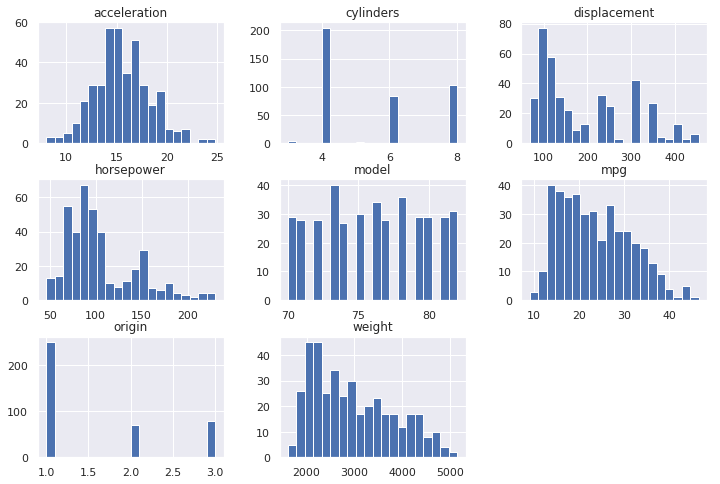

In [9]:
# let's visualize the distribution of the features of the cars
cars.hist(figsize=(12,8),bins=20)
plt.show()

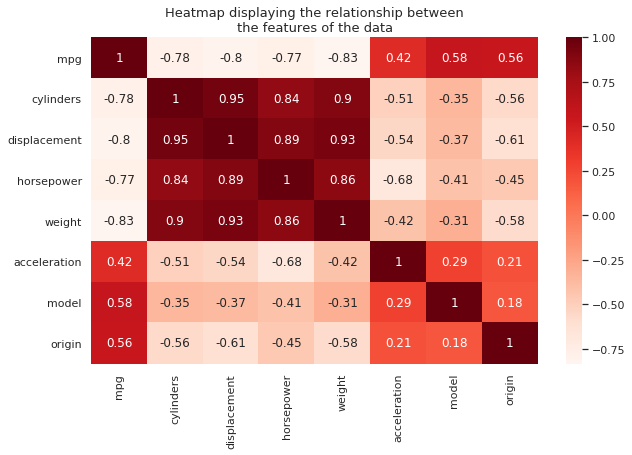

In [10]:
# Let's visualize the relationships between the Mileage Per Galon(mpg) of a car and....
#.... the other features.
plt.figure(figsize=(10,6))
sns.heatmap(cars.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between\nthe features of the data',
         fontsize=13)
plt.show()

In [11]:
# We can also check for multicollinearity using the variance inflation factor.
# A variable/feature affected by multicollinearity will have a value greater than 5....
#...... when we print out the series from the variance inflation factor
# We will have to do a feature selection to get rid of the multicollinearity.

X1 = sm.tools.add_constant(cars) 

series1 = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],
                  index=X1.columns)

# Let's drop the columns that highly correlate with each other
newcars = cars.drop(['cylinders','displacement','weight'],axis=1)

# Let's do the variance inflation factor method again after doing a feature selection....
#..... to see if there's still multicollinearity.
X2 = sm.tools.add_constant(newcars)

series2 = pd.Series([variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])],
                  index=X2.columns)

print('Series before feature selection: \n\n{}\n'.format(series1))
print('Series after feature selection: \n\n{}'.format(series2))

Series before feature selection: 

const           780.806732
mpg               5.583604
cylinders        10.742595
displacement     22.161456
horsepower        9.057010
weight           13.468497
acceleration      2.515892
model             1.954983
origin            1.853451
dtype: float64

Series after feature selection: 

const           715.683761
mpg               3.982206
horsepower        4.131289
acceleration      2.029527
model             1.607080
origin            1.542532
dtype: float64


In [12]:
# print the correlation between the mpg and the remaining variables
print('Correlation between mpg and the remaining variables:\n\n{}'.format(newcars.corr().mpg))

Correlation between mpg and the remaining variables:

mpg             1.000000
horsepower     -0.771543
acceleration    0.420289
model           0.579267
origin          0.563450
Name: mpg, dtype: float64


In [13]:
X = newcars.drop('mpg',axis=1)  # create a DataFrame of feature/independent variables
y = newcars.mpg   # create a series of the dependent variable

# the feature/independent variables are not of the same scale so we scale them 
# this is only neccessary for the LinearRegression,Ridge and Lasso models
# scaling the feature variables ensures fast computing.
X_scaled = preprocessing.scale(X)

# preprocessing.scale() returns a 2-d array not a DataFrame so we make our scaled variables
# a DataFrame.
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

# split our data into training and testing data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.3,random_state=0)

model = LinearRegression()  # initialize the LinearRegression model
model.fit(X_train,y_train)  # we fit the model with the training data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
linear_pred = model.predict(X_test)  # make prediction with the fitted model

# score the model on the train set
print('Train score: {}\n'.format(model.score(X_train,y_train)))
# score the model on the test set
print('Test score: {}\n'.format(model.score(X_test,y_test)))
# calculate the overall accuracy of the model
print('Overall model accuracy: {}\n'.format(r2_score(y_test,linear_pred)))
# compute the mean squared error of the model
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,linear_pred)))

Train score: 0.7553135661809439

Test score: 0.7271939488775567

Overall model accuracy: 0.7271939488775567

Mean Squared Error: 17.43282026200509


In [15]:
# let's fit a ridge regression model and see if we can get a higher accuracy
ridge = Ridge(alpha=.01)
ridge.fit(X_train,y_train)  # fit the model with the training data

ridge_pred = ridge.predict(X_test)  # make predictions

# score the model to check the accuracy
print('Train score: {}\n'.format(ridge.score(X_train,y_train)))
print('Test score: {}\n'.format(ridge.score(X_test,y_test)))
print('Overall model accuracy: {}\n'.format(r2_score(y_test,ridge_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test,ridge_pred)))

Train score: 0.7553135647960986

Test score: 0.7271921092249626

Overall model accuracy: 0.7271921092249626

Mean Squared Error: 17.43293781926926


In [16]:
# we now try to tune the parameters of the ridge model for a better accuracy
# we use a grid search to find the best parameters for the ridge model
ridge_model = Ridge()

param = {'alpha':[0,0.1,0.01,0.001,1]}  # define the parameters

# initialize the grid search
ridge_search = GridSearchCV(ridge_model,param,cv=5,n_jobs=-1)

ridge_search.fit(X_train,y_train)   # fit the model 

/Users/guru/miniconda3/envs/Neural_Networks_and_Deep_Learning/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.01, 0.001, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
# print out the best parameter for ridge and score it on the test and train data

print('Best parameter found:\n{}'.format(ridge_search.best_params_))
print('Train score: {}\n'.format(ridge_search.score(X_train,y_train)))
print('Test score: {}'.format(ridge_search.score(X_test,y_test)))

Best parameter found:
{'alpha': 1}
Train score: 0.7553000451656908

Test score: 0.726999466880118


In [18]:
# let's try and fit a Lasso model for the regression
# here, we just move on to making the grid search and find the best parameters
lasso = Lasso()

param['max_iter'] = [1000,10000,100000,1000000]

lasso_search = GridSearchCV(lasso,param,cv=5,n_jobs=-1) # initialize the grid search

lasso_search.fit(X_train,y_train)  # fit the model

# print out the best parameters and score it 
print('Best parameter found:\n{}\n'.format(lasso_search.best_params_))
print('Train score: {}\n'.format(lasso_search.score(X_train,y_train)))
print('Test score: {}'.format(lasso_search.score(X_test,y_test)))

Best parameter found:
{'alpha': 0, 'max_iter': 1000}

Train score: 0.7553135661809438

Test score: 0.7271939488775568


/Users/guru/miniconda3/envs/Neural_Networks_and_Deep_Learning/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/guru/miniconda3/envs/Neural_Networks_and_Deep_Learning/lib/python3.6/site-packages/sklearn/model_selection/_search.py:714: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/Users/guru/miniconda3/envs/Neural_Networks_and_Deep_Learning/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Users/guru/miniconda3/envs/Neural_Networks_and_Deep_Learning/lib/python3.6/site-packages/sklearn/

In [49]:
# we move on to using the ensemble methods for the regression
# split the unscaled/original X and y data into training and testing data
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.2)

In [50]:
dtree = DecisionTreeRegressor() # initialize a DecisionTreeRegressor model

params = {'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9],
         'min_samples_leaf':[1,2,3,4,5,6,7,8,9],
         'max_depth':[2,3,4,5,6,7]}                # define the hyperparameters

tree_search = GridSearchCV(dtree,params,cv=5,n_jobs=-1)  # initialize the grid search

tree_search.fit(xtrain,ytrain)   # fit the model

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
               

In [51]:
tree_pred = tree_search.predict(xtest)  # make predictions with the model

# print out the best parameters found and score the model
print('Best parameter found:\n{}\n'.format(tree_search.best_params_))
print('Train score: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Test score: {}\n'.format(tree_search.score(xtest,ytest)))
print('Overall model accuracy: {}\n'.format(r2_score(ytest,tree_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(ytest,tree_pred)))

Best parameter found:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8}

Train score: 0.8659010496323457

Test score: 0.7924277458046822

Overall model accuracy: 0.7924277458046822

Mean Squared Error: 11.387723926209835


In [52]:
# we now fit a RandomForestRegressor model and perform a grid search to find the best 
# parameters
forest = RandomForestRegressor()

# we add the n_estimators parameter in our previous parameter dictionary
params['n_estimators'] = [100,200,300,400,500]

forest_search = RandomizedSearchCV(forest,params,cv=5,n_jobs=-1,     # initialize the search
                                  n_iter=50)

forest_search.fit(xtrain,ytrain)  # fit the model

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [53]:
forest_pred = forest_search.predict(xtest)  # make prediction with the model

# print out the best parameters and score the model
print('Best parameter found:\n{}\n'.format(forest_search.best_params_))
print('Train score: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Test score: {}\n'.format(forest_search.score(xtest,ytest)))
print('Overall model accuracy: {}\n'.format(r2_score(ytest,forest_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(ytest,forest_pred)))

Best parameter found:
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 7}

Train score: 0.9398968300990964

Test score: 0.8047191903918415

Overall model accuracy: 0.8047191903918415

Mean Squared Error: 10.71339691581293


In [59]:
# train a GradientBoostingRegressor model

gradient_model = GradientBoostingRegressor()  # instantiate the model

# append a learning_rate parameter to the parameter dictionary
params['learning_rate'] = [0.05,0.1,0.2,0.3,0.4,0.5]

gradient_search = RandomizedSearchCV(gradient_model,params,cv=5,n_jobs=-1,
                                  n_iter=50)   # initialize the search

gradient_search.fit(xtrain,ytrain)   # fit the model

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

In [60]:
gradient_pred = gradient_search.predict(xtest)  # make predictions with the model

# print out the best parameters and score the model
print('Best parameter found:\n{}\n'.format(gradient_search.best_params_))
print('Train score: {}\n'.format(gradient_search.score(xtrain,ytrain)))
print('Test score: {}\n'.format(gradient_search.score(xtest,ytest)))
print('Overall model accuracy: {}\n'.format(r2_score(ytest,gradient_pred)))
print('Mean Squared Error: {}\n'.format(mean_squared_error(ytest,gradient_pred)))
print('Looks like this model is not too overfitted and it has low mean squared error \
so we use this one........')

Best parameter found:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 2, 'learning_rate': 0.1}

Train score: 0.9040700029438588

Test score: 0.8379811577934175

Overall model accuracy: 0.8379811577934175

Mean Squared Error: 8.888595699098659

Looks like this model is not too overfitted and it has low mean squared error so we use this one........


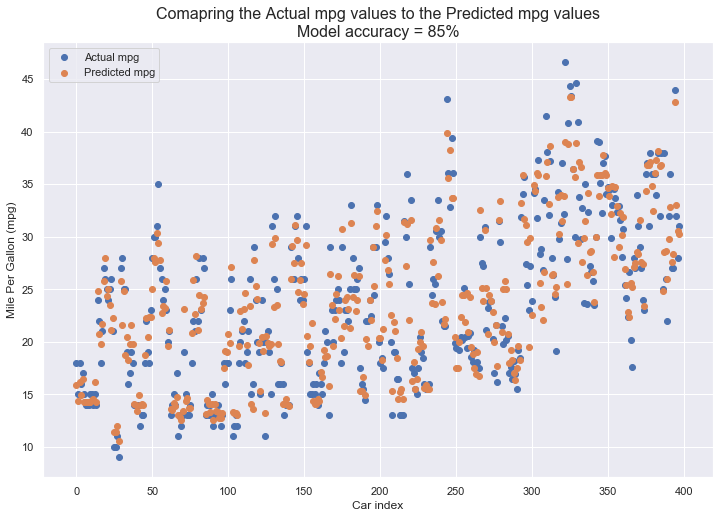

In [77]:
# we will now try to make predictions and see how well our model predicts
# we will visualize the actual mpg values recorded and the mpg values predicted by our 
# model to see how close our predictions are to the actual values.

newcars_new = newcars.drop('mpg',axis=1)  # create a new DataFrame of the feature variables

# make a DataFrame of the actual mpg and the predicted mpg 
data = pd.DataFrame({'Actual mpg':newcars.mpg.values,
                    'Predicted mpg':gradient_search.predict(newcars_new.values)})


# make a scatter plot of the actual and the predicted mpg of a car
plt.figure(figsize=(12,8))
plt.scatter(data.index,data['Actual mpg'].values,label='Actual mpg')
plt.scatter(data.index,data['Predicted mpg'].values,label='Predicted mpg')
plt.title('Comapring the Actual mpg values to the Predicted mpg values\nModel accuracy = 85%',
         fontsize=16)
plt.xlabel('Car index')
plt.ylabel('Mile Per Gallon (mpg)')
plt.legend(loc='upper left')
plt.show()

In [ ]:
"""We can see from the above scatter plot that our model made a good predictions
   as the values of the actual mpg and the predicted mpg are very close to each
   other.
   We can confidently say that we have succeeded in training a model that predicts 
   the Mileage Per Gallon (mpg) of a car given the acceleration,model,origin and 
   the horsepower of a car."""